In [98]:
!pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [123]:
#import package, if it does not work, restart the console and re-run this command.
import mysql.connector

In [124]:
#input the credentials
connection = mysql.connector.connect(
    host="127.0.0.1",  # Hostname
    user="sripanja",   # Username
    password="campy upheaval cleat grackle",  # Password
    database="sripanja_db"  # Database name
)

cursor = connection.cursor()

# Create Location table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Location (
    LocationID INT PRIMARY KEY,
    city VARCHAR(100) NOT NULL,
    state VARCHAR(100) NOT NULL
);
''')

# Create Patient table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Patient (
    pid INT PRIMARY KEY,
    fname VARCHAR(100) NOT NULL,
    lname VARCHAR(100) NOT NULL,
    DOB DATE NOT NULL,
    sex VARCHAR(10) NOT NULL,
    LocationID INT,
    FOREIGN KEY (LocationID) REFERENCES Location(LocationID)
);
''')

# Create Form_Encounter table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Form_Encounter (
    encounter_id INT PRIMARY KEY,
    pid INT,
    date DATE,
    reason VARCHAR(255),
    FOREIGN KEY (pid) REFERENCES Patient(pid)
);
''')

# Create Prescription table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Prescription (
    prescriptionID INT PRIMARY KEY,
    pid INT,
    date_added DATE,
    dosage VARCHAR(255),
    drug VARCHAR(255),
    unit VARCHAR(50),
    route VARCHAR(100),
    encounter_id INT,
    FOREIGN KEY (pid) REFERENCES Patient(pid),
    FOREIGN KEY (encounter_id) REFERENCES Form_Encounter(encounter_id)
);
''')

# Create Vitals table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Vitals (
    vital_id INT PRIMARY KEY,
    pid INT,
    date DATE,
    weight FLOAT,
    height FLOAT,
    temperature FLOAT,
    pulse FLOAT,
    respiration FLOAT,
    encounter_id INT,
    FOREIGN KEY (pid) REFERENCES Patient(pid),
    FOREIGN KEY (encounter_id) REFERENCES Form_Encounter(encounter_id)
);
''')

# Create Procedure_Order table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Procedure_Order (
    procedure_order_id INT PRIMARY KEY,
    encounter_id INT,
    date_ordered DATE,
    order_status VARCHAR(100),
    activity VARCHAR(100),
    procedure_order_type VARCHAR(100),
    FOREIGN KEY (encounter_id) REFERENCES Form_Encounter(encounter_id)
);
''')

# Create Procedure_Report table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Procedure_Report (
    procedure_report_id INT PRIMARY KEY,
    procedure_order_id INT,
    date_report DATE,
    report_status VARCHAR(100),
    review_status VARCHAR(100),
    FOREIGN KEY (procedure_order_id) REFERENCES Procedure_Order(procedure_order_id)
);
''')

print("✅ All tables created successfully!")



✅ All tables created successfully!


In [125]:
import pandas as pd
import csv

In [154]:
import mysql.connector
import pandas as pd

# Step 1: Connect to MySQL
connection = mysql.connector.connect(
    host="127.0.0.1",
    user="sripanja",
    password="campy upheaval cleat grackle",
    database="sripanja_db"
)
cursor = connection.cursor()

# Step 2: Load the vitals CSV
vitals_df = pd.read_csv('cleaned_form_vitals.csv')

# Step 3: Get valid encounter IDs from Form_Encounter
cursor.execute("SELECT encounter_id FROM Form_Encounter")
valid_encounters = set(row[0] for row in cursor.fetchall())

# Step 4: Filter vitals where encounter_id is valid
filtered_vitals = vitals_df[vitals_df['encounter_id'].isin(valid_encounters)]

print(f"✅ Total valid vitals rows to insert: {len(filtered_vitals)}")

# Step 5: Insert valid rows using INSERT IGNORE
for _, row in filtered_vitals.iterrows():
    cursor.execute('''
        INSERT IGNORE INTO Vitals 
        (vital_id, pid, date, weight, height, temperature, pulse, respiration, encounter_id)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
    ''', (
        row['vital_id'],
        row['pid'],
        row['date'],
        row['weight'],
        row['height'],
        row['temperature'],
        row['pulse'],
        row['respiration'],
        row['encounter_id']
    ))

# Step 6: Commit and cleanup
connection.commit()
print("✅ Vitals inserted successfully!")



✅ Total valid vitals rows to insert: 6
✅ Vitals inserted successfully!


In [147]:
# Load CSV
location_df = pd.read_csv('location.csv')

# Insert into Location table using INSERT IGNORE
for _, row in location_df.iterrows():
    cursor.execute('''
        INSERT IGNORE INTO Location (LocationID, city, state)
        VALUES (%s, %s, %s)
    ''', (row['LocationID'], row['city'], row['state']))

# Commit changes (use your existing connection)
connection.commit()

print("✅ Location data inserted successfully without duplicates!")


✅ Location data inserted successfully without duplicates!


In [148]:
# Load the cleaned patient data
patient_df = pd.read_csv('cleaned_patient_data.csv')

# Insert into Patient table safely
for _, row in patient_df.iterrows():
    cursor.execute('''
        INSERT IGNORE INTO Patient (pid, fname, lname, DOB, sex, LocationID)
        VALUES (%s, %s, %s, %s, %s, %s)
    ''', (row['pid'], row['fname'], row['lname'], row['DOB'], row['sex'], row['LocationID']))

# Commit changes
connection.commit()

In [149]:
encounter_df = pd.read_csv('cleaned_form_encounter.csv')

for _, row in encounter_df.iterrows():
    cursor.execute('''
        INSERT IGNORE INTO Form_Encounter (encounter_id, pid, date, reason)
        VALUES (%s, %s, %s, %s)
    ''', (row['encounter_id'], row['pid'], row['date'], row['reason']))

connection.commit()


In [150]:
prescription_df = pd.read_csv('cleaned_prescriptions.csv')

for _, row in prescription_df.iterrows():
    cursor.execute('''
        INSERT IGNORE INTO Prescription (prescriptionID, pid, date_added, dosage, drug, unit, route, encounter_id)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    ''', (row['prescriptionID'], row['pid'], row['date_added'], row['dosage'], row['drug'], row['unit'], row['route'], row['encounter_id']))

connection.commit()


In [151]:
# vitals_df = pd.read_csv('cleaned_form_vitals.csv')

# for _, row in vitals_df.iterrows():
#     cursor.execute('''
#         INSERT IGNORE INTO Vitals (vital_id, pid, date, weight, height, temperature, pulse, respiration, encounter_id)
#         VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
#     ''', (row['vital_id'], row['pid'], row['date'], row['weight'], row['height'], row['temperature'], row['pulse'], row['respiration'], row['encounter_id']))

# connection.commit()

vitals_df = pd.read_csv('cleaned_form_vitals.csv')

for _, row in vitals_df.iterrows():
    cursor.execute('''
        INSERT IGNORE INTO Vitals (vital_id, pid, date, weight, height, temperature, pulse, respiration, encounter_id)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
    ''', (
        row['vital_id'], row['pid'], row['date'], row['weight'],
        row['height'], row['temperature'], row['pulse'], 
        row['respiration'], row['encounter_id']
    ))
connection.commit()

In [152]:
procedure_order_df = pd.read_csv('cleaned_procedure_order.csv')

for _, row in procedure_order_df.iterrows():
    cursor.execute('''
        INSERT IGNORE INTO Procedure_Order (procedure_order_id, encounter_id, date_ordered, order_status, activity, procedure_order_type)
        VALUES (%s, %s, %s, %s, %s, %s)
    ''', (row['procedure_order_id'], row['encounter_id'], row['date_ordered'], row['order_status'], row['activity'], row['procedure_order_type']))

connection.commit()

In [140]:
procedure_report_df = pd.read_csv('cleaned_procedure_report.csv')

for _, row in procedure_report_df.iterrows():
    cursor.execute('''
        INSERT IGNORE INTO Procedure_Report (procedure_report_id, procedure_order_id, date_report, report_status, review_status)
        VALUES (%s, %s, %s, %s, %s)
    ''', (row['procedure_report_id'], row['procedure_order_id'], row['date_report'], row['report_status'], row['review_status']))

connection.commit()

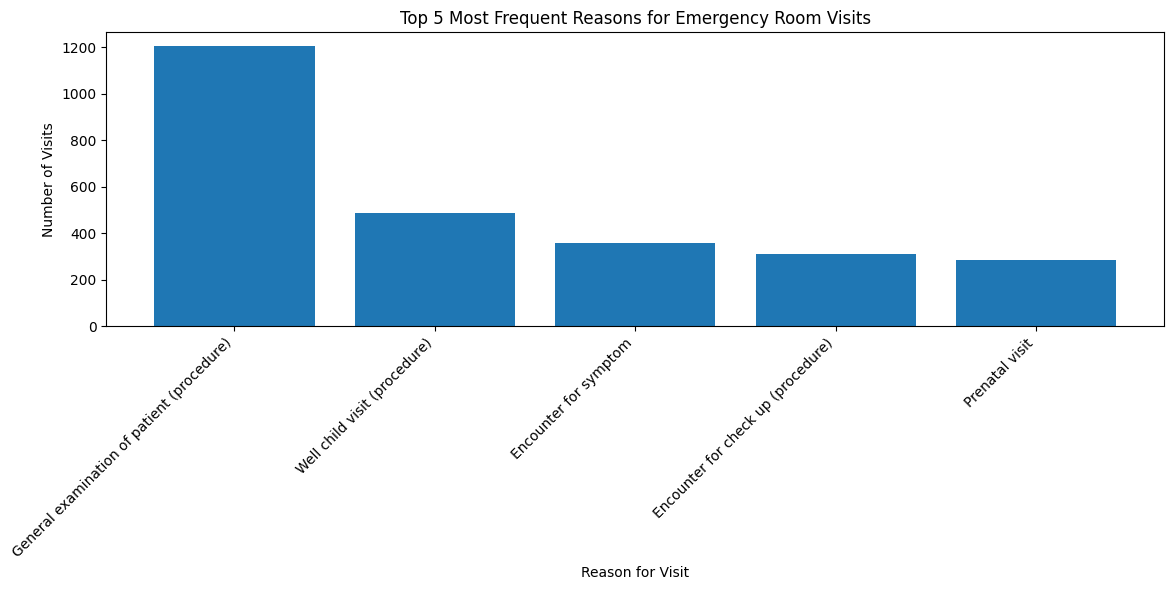

In [141]:
# Q1: What are the most frequent reasons for emergency room visits?
cursor.execute('''
    SELECT reason, COUNT(*) AS visit_count
    FROM Form_Encounter
    GROUP BY reason
    ORDER BY visit_count DESC
    LIMIT 5;
''')

#Fetch the results
result = cursor.fetchall()

#Load into a DataFrame
reason_df = pd.DataFrame(result, columns=['Reason', 'Visit_Count'])

#Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(reason_df['Reason'], reason_df['Visit_Count'])
plt.xlabel('Reason for Visit')
plt.ylabel('Number of Visits')
plt.title('Top 5 Most Frequent Reasons for Emergency Room Visits')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


✅ Sample Admission Reasons:
Emergency room admission (procedure)
Admission to skilled nursing facility (procedure)
Obstetric emergency hospital admission
Emergency Room Admission
Hospital admission (procedure)
Admission to ward (procedure)
Emergency hospital admission for asthma
Admission to hospice (procedure)
Admission to surgical department

✅ Aggregated Results:
('Not Hospitalized', Decimal('6'), Decimal('0'), Decimal('0'))


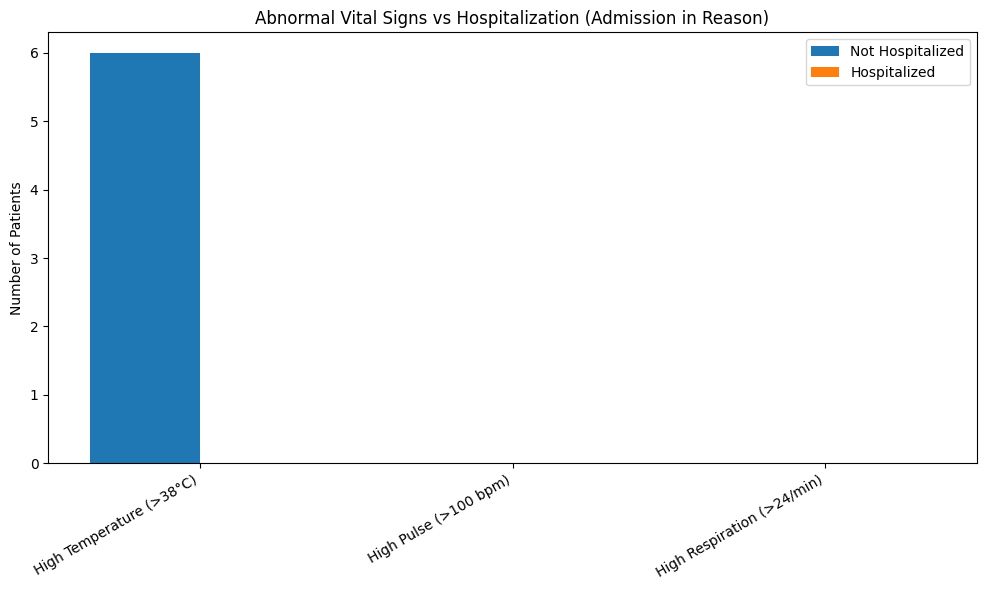

In [156]:
# # # #Q2: Are there patterns in patient vital signs that indicate a higher risk of hospitalization after an ER visit?



import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




# Step 1: Print sample "reason" values to verify they contain 'Admission'
cursor.execute("SELECT DISTINCT reason FROM Form_Encounter WHERE reason LIKE '%Admission%' LIMIT 10;")
print("✅ Sample Admission Reasons:")
for row in cursor.fetchall():
    print(row[0])

# Step 2: SQL Query
query = '''
SELECT 
    summary.Hospitalized,
    SUM(summary.High_Temperature) AS High_Temperature,
    SUM(summary.High_Pulse) AS High_Pulse,
    SUM(summary.High_Respiration) AS High_Respiration
FROM (
    SELECT 
        CASE 
            WHEN LOWER(fe.reason) LIKE '%admission%' THEN 'Hospitalized'
            ELSE 'Not Hospitalized'
        END AS Hospitalized,
        CASE WHEN v.temperature > 38 THEN 1 ELSE 0 END AS High_Temperature,
        CASE WHEN v.pulse > 100 THEN 1 ELSE 0 END AS High_Pulse,
        CASE WHEN v.respiration > 24 THEN 1 ELSE 0 END AS High_Respiration
    FROM 
        Vitals v
    INNER JOIN 
        Form_Encounter fe ON v.encounter_id = fe.encounter_id
    WHERE 
        v.temperature IS NOT NULL 
        AND v.pulse IS NOT NULL 
        AND v.respiration IS NOT NULL
) AS summary
GROUP BY 
    summary.Hospitalized;

'''

cursor.execute(query)
result = cursor.fetchall()

# Print results to check
print("\n✅ Aggregated Results:")
for r in result:
    print(r)

# Convert to DataFrame
df = pd.DataFrame(result, columns=['Hospitalized', 'High_Temperature', 'High_Pulse', 'High_Respiration'])

# Step 3: Plot
abnormal_counts = {
    'High Temperature (>38°C)': df['High_Temperature'].values,
    'High Pulse (>100 bpm)': df['High_Pulse'].values,
    'High Respiration (>24/min)': df['High_Respiration'].values
}

x = np.arange(len(abnormal_counts))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, [counts[0] for counts in abnormal_counts.values()], width, label='Not Hospitalized')
rects2 = ax.bar(x + width/2, [counts[1] if len(counts) > 1 else 0 for counts in abnormal_counts.values()], width, label='Hospitalized')

ax.set_ylabel('Number of Patients')
ax.set_title('Abnormal Vital Signs vs Hospitalization (Admission in Reason)')
ax.set_xticks(x)
ax.set_xticklabels(abnormal_counts.keys(), rotation=30, ha='right')
ax.legend()
plt.tight_layout()
plt.show()



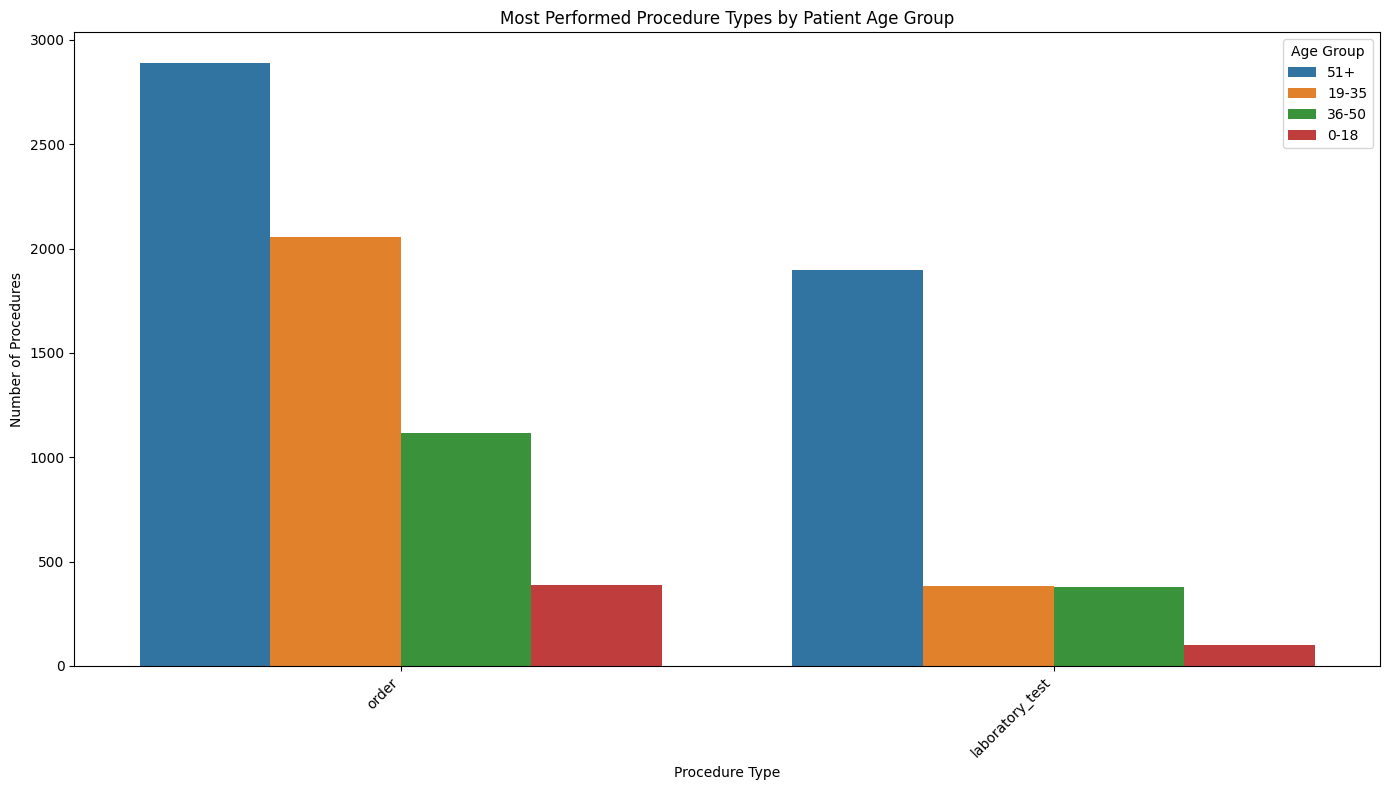

In [112]:
from datetime import datetime


cursor.execute('''
    SELECT 
        po.procedure_order_type,
        CASE 
            WHEN TIMESTAMPDIFF(YEAR, pa.DOB, CURDATE()) <= 18 THEN '0-18'
            WHEN TIMESTAMPDIFF(YEAR, pa.DOB, CURDATE()) <= 35 THEN '19-35'
            WHEN TIMESTAMPDIFF(YEAR, pa.DOB, CURDATE()) <= 50 THEN '36-50'
            ELSE '51+'
        END AS Age_Group,
        COUNT(*) AS Procedure_Count
    FROM 
        Procedure_Order po
    JOIN 
        Form_Encounter fe ON po.encounter_id = fe.encounter_id
    JOIN 
        Patient pa ON fe.pid = pa.pid
    WHERE 
        po.procedure_order_type IS NOT NULL
    GROUP BY 
        po.procedure_order_type, Age_Group
    ORDER BY 
        Procedure_Count DESC;
''')

#Load into DataFrame
result = cursor.fetchall()
procedure_df = pd.DataFrame(result, columns=['Procedure_Order_Type', 'Age_Group', 'Procedure_Count'])

#Visualization
#Set figure size
plt.figure(figsize=(14,8))

#Create a grouped bar chart
sns.barplot(
    data=procedure_df,
    x='Procedure_Order_Type',
    y='Procedure_Count',
    hue='Age_Group'
)

#Customize chart
plt.title('Most Performed Procedure Types by Patient Age Group')
plt.xlabel('Procedure Type')
plt.ylabel('Number of Procedures')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Age Group')
plt.tight_layout()

#Show chart
plt.show()


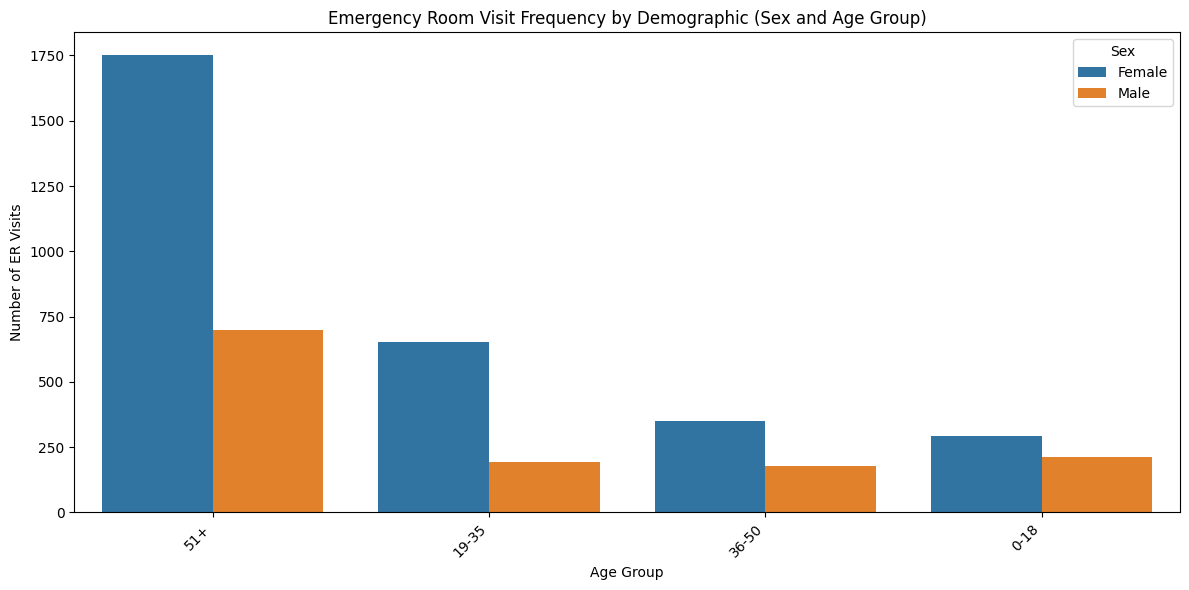

In [113]:
#Q4: Are there differences in emergency room visit frequency based on demographics?

cursor.execute('''
    SELECT 
        pa.sex,
        CASE 
            WHEN TIMESTAMPDIFF(YEAR, pa.DOB, CURDATE()) <= 18 THEN '0-18'
            WHEN TIMESTAMPDIFF(YEAR, pa.DOB, CURDATE()) <= 35 THEN '19-35'
            WHEN TIMESTAMPDIFF(YEAR, pa.DOB, CURDATE()) <= 50 THEN '36-50'
            ELSE '51+'
        END AS Age_Group,
        COUNT(*) AS Visit_Count
    FROM 
        Form_Encounter fe
    JOIN 
        Patient pa ON fe.pid = pa.pid
    GROUP BY 
        pa.sex, Age_Group
    ORDER BY 
        Visit_Count DESC;
''')

#Fetch into DataFrame
result = cursor.fetchall()
demographics_df = pd.DataFrame(result, columns=['Sex', 'Age_Group', 'Visit_Count'])

#Visualization (Bar Chart)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(
    data=demographics_df,
    x='Age_Group',
    y='Visit_Count',
    hue='Sex'
)
plt.title('Emergency Room Visit Frequency by Demographic (Sex and Age Group)')
plt.xlabel('Age Group')
plt.ylabel('Number of ER Visits')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

✅ ER Follow-up Prescription Statistics:
Total ER Patients: 100
Patients with Prescriptions: 97
Patients without Prescriptions: 3
Percentage of Patients Getting Prescriptions: 97.00%
Percentage of Patients Not Getting Prescriptions: 3.00%


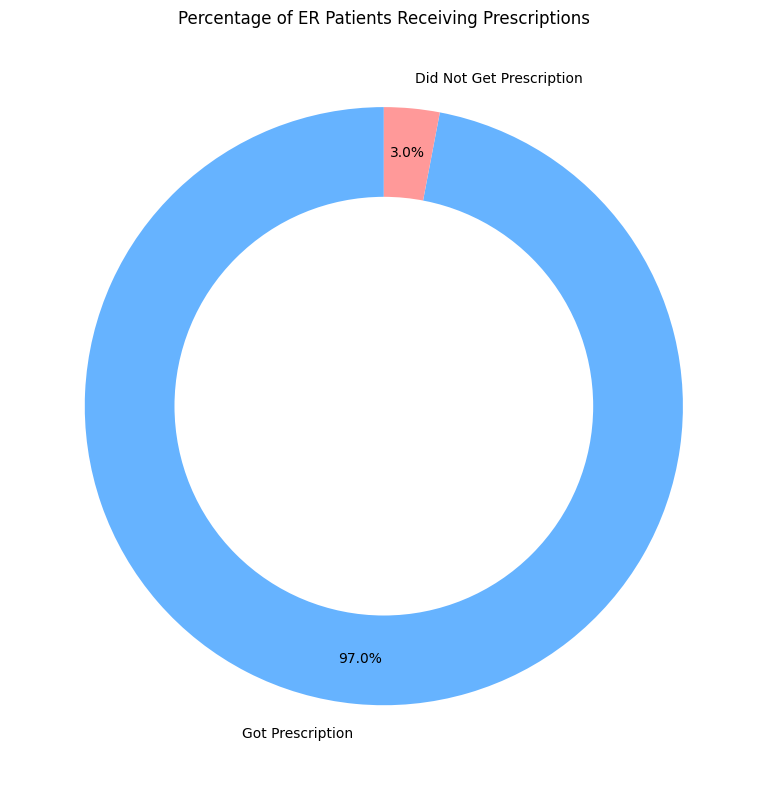


✅ Top 5 Most Prescribed Medications (Among ER Patients with Prescriptions):
                                                Drug  Prescription_Count
0                   Acetaminophen 325 MG Oral Tablet                  38
1  Amoxicillin 250 MG / Clavulanate 125 MG Oral T...                  21
2                       lisinopril 10 MG Oral Tablet                  21
3                 Naproxen sodium 220 MG Oral Tablet                  19
4              Hydrochlorothiazide 25 MG Oral Tablet                  16


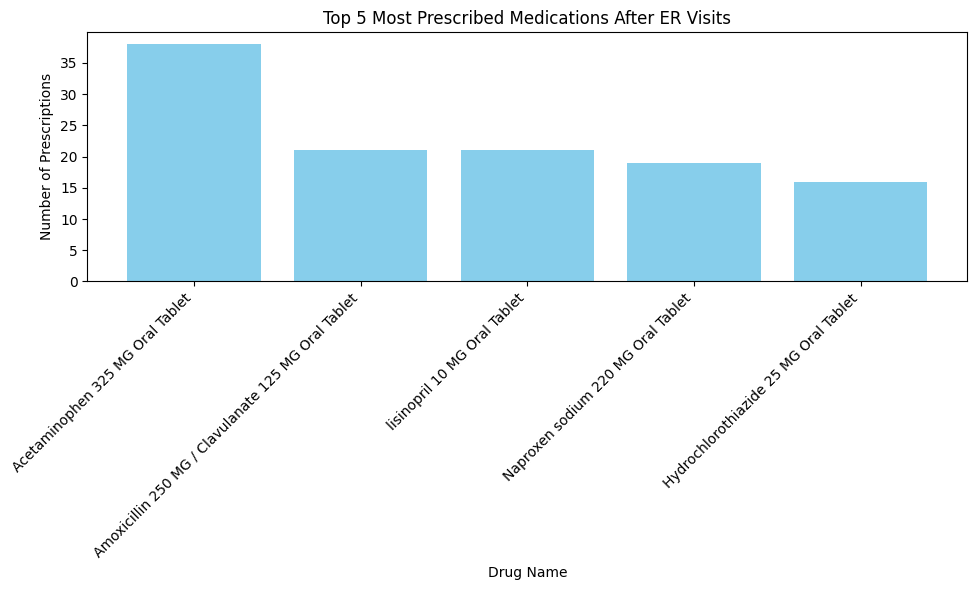

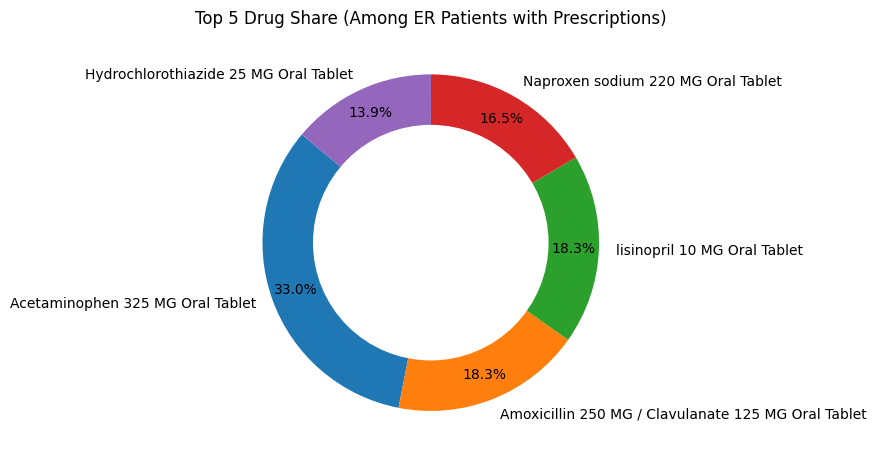

In [114]:
# Q5: How often do emergency room patients require follow-up prescriptions, and what are the most prescribed medications?
#Step 1: Get total distinct patients from Form_Encounter

cursor.execute('''
    SELECT COUNT(DISTINCT pid) FROM Form_Encounter
''')
total_patients = cursor.fetchone()[0]

#Step 2: Get distinct patients who received at least one prescription
cursor.execute('''
    SELECT COUNT(DISTINCT fe.pid)
    FROM Prescription p
    JOIN Form_Encounter fe ON p.encounter_id = fe.encounter_id
''')
patients_with_prescription = cursor.fetchone()[0]

#Step 3: Calculate percentages
patients_without_prescription = total_patients - patients_with_prescription
percentages = [
    (patients_with_prescription / total_patients) * 100,
    (patients_without_prescription / total_patients) * 100
]

# Display
print("✅ ER Follow-up Prescription Statistics:")
print(f"Total ER Patients: {total_patients}")
print(f"Patients with Prescriptions: {patients_with_prescription}")
print(f"Patients without Prescriptions: {patients_without_prescription}")
print(f"Percentage of Patients Getting Prescriptions: {percentages[0]:.2f}%")
print(f"Percentage of Patients Not Getting Prescriptions: {percentages[1]:.2f}%")

#Step 4: Visualization - Pie Chart for Prescription Percentage
labels = ['Got Prescription', 'Did Not Get Prescription']

plt.figure(figsize=(8,8))
plt.pie(
    percentages,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999'],
    pctdistance=0.85
)

# Donut center
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Percentage of ER Patients Receiving Prescriptions')
plt.tight_layout()
plt.show()

#Step 5: SQL Query - Top 5 Prescribed Medications
cursor.execute('''
    SELECT 
        p.drug,
        COUNT(*) AS prescription_count
    FROM 
        Prescription p
    JOIN 
        Form_Encounter fe ON p.encounter_id = fe.encounter_id
    WHERE 
        p.drug IS NOT NULL
    GROUP BY 
        p.drug
    ORDER BY 
        prescription_count DESC
    LIMIT 5;
''')

# Fetch and load
result = cursor.fetchall()
top_drugs_df = pd.DataFrame(result, columns=['Drug', 'Prescription_Count'])

# Display
print("\n✅ Top 5 Most Prescribed Medications (Among ER Patients with Prescriptions):")
print(top_drugs_df)

#Step 6: Visualization - Bar Chart for Top 5 Drugs
plt.figure(figsize=(10,6))
plt.bar(top_drugs_df['Drug'], top_drugs_df['Prescription_Count'], color='skyblue')
plt.title('Top 5 Most Prescribed Medications After ER Visits')
plt.xlabel('Drug Name')
plt.ylabel('Number of Prescriptions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Step 7: Visualization - Pie Chart for Top 5 Drug Share
plt.figure(figsize=(8,8))
plt.pie(
    top_drugs_df['Prescription_Count'],
    labels=top_drugs_df['Drug'],
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=0.85
)

# Donut center
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Top 5 Drug Share (Among ER Patients with Prescriptions)')
plt.tight_layout()
plt.show()
